In [1]:
%matplotlib inline
from keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
MODEL_NAME = 'mnist_cnn'
EPOCHS = 30
BATCH_SIZE = 32

In [3]:
# Load the MNIST dataset directly through Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data into tensor format
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Convert training labels to 1-hot binary vectors
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)

# Create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [6]:
stop_callback = EarlyStopping(patience=7)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1)

H = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
              validation_data=(x_val, y_val), callbacks=[stop_callback, reduce_lr])

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 43s 792us/step - loss: 0.2552 - acc: 0.9211 - val_loss: 0.0697 - val_acc: 0.9787
Epoch 2/30
54000/54000 [==============================] - 39s 719us/step - loss: 0.0803 - acc: 0.9752 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 3/30
54000/54000 [==============================] - 39s 728us/step - loss: 0.0653 - acc: 0.9802 - val_loss: 0.0284 - val_acc: 0.9920
Epoch 4/30
54000/54000 [==============================] - 38s 704us/step - loss: 0.0549 - acc: 0.9830 - val_loss: 0.0314 - val_acc: 0.9908
Epoch 5/30
54000/54000 [==============================] - 38s 706us/step - loss: 0.0517 - acc: 0.9839 - val_loss: 0.0273 - val_acc: 0.9917
Epoch 6/30
54000/54000 [==============================] - 39s 729us/step - loss: 0.0422 - acc: 0.9871 - val_loss: 0.0290 - val_acc: 0.9913
Epoch 7/30
54000/54000 [==============================] - 40s 733us/step - loss: 0.0394 - acc: 0.9879 - val_loss: 0.0

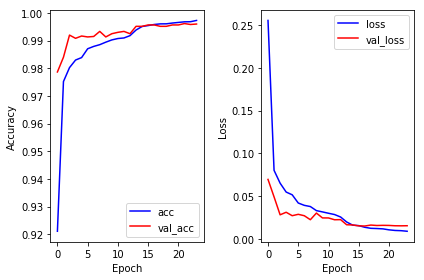

In [7]:
# Plot the accuracies
plt.subplot(121)
plt.plot(H.history['acc'], 'b', label='acc')
plt.plot(H.history['val_acc'], 'r', label='val_acc')
plt.xticks(np.arange(len(H.history['acc']), step=5))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the losses
plt.subplot(122)
plt.plot(H.history['loss'], 'b', label='loss')
plt.plot(H.history['val_loss'], 'r', label='val_loss')
plt.xticks(np.arange(len(H.history['loss']), step=5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [11]:
# Reload the model with the lowest validation loss (if necessary)
model = load_model('{}.h5'.format(MODEL_NAME))

In [8]:
print('[Training Data]')
loss, acc = model.evaluate(x_train, y_train, verbose=1)
print('Loss: {}\nAccuracy: {}%'.format(loss, acc))

[Training Data]
54000/54000 [==============================] - 11s 196us/step
Loss: 0.0021448809403932334
Accuracy: 0.9994814814814815%


In [9]:
print('[Testing Data]')
loss, acc = model.evaluate(x_test, binarizer.transform(y_test), verbose=1)
print('Loss: {}\nAccuracy: {}%'.format(loss, acc))

[Testing Data]
10000/10000 [==============================] - 2s 194us/step
Loss: 0.012607622316906781
Accuracy: 0.996%


In [11]:
# Generate predictions
probs = model.predict(x_test)
preds = probs.argmax(axis=1)

# Display classification report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       0.99      1.00      1.00      1135
          2       1.00      1.00      1.00      1032
          3       1.00      1.00      1.00      1010
          4       0.99      1.00      0.99       982
          5       0.99      0.99      0.99       892
          6       1.00      0.99      1.00       958
          7       1.00      1.00      1.00      1028
          8       1.00      1.00      1.00       974
          9       1.00      0.99      0.99      1009

avg / total       1.00      1.00      1.00     10000



In [15]:
# Predict labels for random test images
while True:
    # Choose a random image from the test set
    i = np.random.choice(np.arange(x_test.shape[0]), size=(1,), replace=False)[0]
    sample = x_test[i]
    label = y_test[i]
    
    # Predict label for the sampled image
    prob = model.predict(np.expand_dims(sample, axis=0))
    pred = prob.argmax(axis=1)[0]
    print('Image {}: (actual, predicted) = ({}, {})'.format(i, label, pred))

    # Convert grayscale image to color and resize for easy viewing
    img = cv2.cvtColor(sample, cv2.COLOR_GRAY2BGR)
    img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
    # Green if prediction is correct, red otherwise
    color = (0, 127, 0) if pred == label else (0, 0, 127)
    
    # Write prediction and confidence to image and display it
    cv2.putText(img, '{}: {:.1f}%'.format(pred, 100*prob.max()), (0, 20), cv2.FONT_HERSHEY_DUPLEX, 0.8, color)
    cv2.imshow('Image {}: {}'.format(i, label), img)
    
    # Wait for keypress; quit if 'q' is pressed
    if cv2.waitKey(0) == ord('q'):
        break
    
cv2.destroyAllWindows()

Image 5885: (actual, predicted) = (5, 5)
Image 5792: (actual, predicted) = (4, 4)
Image 2387: (actual, predicted) = (9, 9)
Image 5131: (actual, predicted) = (6, 6)
Image 7130: (actual, predicted) = (3, 3)
Image 830: (actual, predicted) = (2, 2)
